In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### 导入数据

In [4]:
df3 = pd.read_excel('附件.xlsx',sheet_name='表单3')
df3.head()

,文物编号,表面风化,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2)
0,A1,无风化,78.45,NaN,NaN,6.08,1.86,7.23,2.15,2.11,NaN,NaN,1.06,0.03,NaN,0.51
1,A2,风化,37.75,NaN,NaN,7.63,NaN,2.33,NaN,NaN,34.30,NaN,14.27,NaN,NaN,NaN
2,A3,无风化,31.95,NaN,1.36,7.19,0.81,2.93,7.06,0.21,39.58,4.69,2.68,0.52,NaN,NaN
3,A4,无风化,35.47,NaN,0.79,2.89,1.05,7.07,6.45,0.96,24.28,8.31,8.45,0.28,NaN,NaN
4,A5,风化,64.29,1.2,0.37,1.64,2.34,12.75,0.81,0.94,12.23,2.16,0.19,0.21,0.49,NaN


In [5]:
df4 = pd.read_excel('附件.xlsx',sheet_name='表单4')
df4 = df4.drop(['文物编号','纹饰','颜色','文物采样点'],axis=1)
df4.head()

,表面风化,二氧化硅(SiO2),氧化钠(Na2O),氧化钾(K2O),氧化钙(CaO),氧化镁(MgO),氧化铝(Al2O3),氧化铁(Fe2O3),氧化铜(CuO),氧化铅(PbO),氧化钡(BaO),五氧化二磷(P2O5),氧化锶(SrO),氧化锡(SnO2),二氧化硫(SO2),类型
0,无风化,69.33,NaN,9.99,6.32,0.87,3.93,1.74,3.87,NaN,NaN,1.17,NaN,NaN,0.39,高钾
1,无风化,87.05,NaN,5.19,2.01,NaN,4.06,NaN,0.78,0.25,NaN,0.66,NaN,NaN,NaN,高钾
2,无风化,61.71,NaN,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,NaN,NaN,高钾
3,无风化,65.88,NaN,9.67,7.12,1.56,6.44,2.06,2.18,NaN,NaN,0.79,NaN,NaN,0.36,高钾
4,无风化,61.58,NaN,10.95,7.35,1.77,7.50,2.62,3.27,NaN,NaN,0.94,0.06,NaN,0.47,高钾


In [6]:
df4.shape

(66, 16)

### 数据预处理

In [14]:
def fill_missing_value(data):
    filled_data = data.copy()
    cols = list(filled_data.columns)
    for col in cols:
        filled_data[col] = filled_data[col].fillna(0)
    return filled_data

def filter_invalid_data(data):
    filtered_data = data.copy()
    cols = list(filtered_data.columns)
    filtered_data['Total'] = filtered_data[cols[1:15]].sum(axis=1)
    filtered_data = filtered_data[(filtered_data['Total'] >= 85) & (filtered_data['Total'] <= 105)]
    return filtered_data
    
def rename_data(data):
    renamed_data = data.copy()
    renamed_data['表面风化'][renamed_data['表面风化'] == '无风化'] = 0
    renamed_data['表面风化'][renamed_data['表面风化'] == '风化'] = 1
    renamed_data = renamed_data.rename(columns={'表面风化':'weathering', 
                              '二氧化硅(SiO2)':'SiO2', 
                              '氧化钠(Na2O)':'Na2O',
                              '氧化钾(K2O)':'K2O',
                              '氧化钙(CaO)':'CaO',
                              '氧化镁(MgO)':'MgO',
                              '氧化铝(Al2O3)':'Al2O3',
                              '氧化铁(Fe2O3)':'Fe2O3',
                              '氧化铜(CuO)':'CuO',
                              '氧化铅(PbO)':'PbO',
                              '氧化钡(BaO)':'BaO',
                              '五氧化二磷(P2O5)':'P2O5',
                              '氧化锶(SrO)':'SrO',
                              '氧化锡(SnO2)':'SnO2',
                              '二氧化硫(SO2)':'SO2'})
    return renamed_data

def process_data_gm(data, pipeline_functions):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    return data

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [15]:
def process_data_fm(data):
    X = data
    X = process_data_gm(X, [
                            (fill_missing_value, None, None),
                            (filter_invalid_data, None, None),
                            (rename_data, None, None),
                            (select_columns, [# Binary Features
                                              'weathering',
                                              # Numerical Features
                                              'SiO2',
                                              'Na2O',
                                              'K2O',
                                              'CaO',
                                              'MgO',
                                              'Al2O3',
                                              'Fe2O3',
                                              'CuO',
                                              'PbO',
                                              'BaO',
                                              'P2O5',
                                              'SrO',
                                              'SnO2',
                                              'SO2'], None)])
    return X

### 【第二题后半问】- K

In [16]:
df4_pca = pd.read_excel('附件.xlsx',sheet_name='表单4')
df4_pca = df4_pca.drop(['文物编号','纹饰','颜色','文物采样点'],axis=1)
df4_pca_K = df4_pca[df4_pca['类型'] == '高钾']
df4_pca_PbBa = df4_pca[df4_pca['类型'] == '铅钡']

### 降维

##### 原数据

In [17]:
a_K = process_data_fm(df4_pca_K.copy())
a_K = a_K[list(a_K.columns)[1:15]]
a_K.to_csv('a_K.csv')
a_K

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.00,0.39
1,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.00,0.00
2,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.00,0.00
3,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.00,0.36
4,61.58,0.00,10.95,7.35,1.77,7.50,2.62,3.27,0.00,0.00,0.94,0.06,0.00,0.47
5,67.65,0.00,7.37,0.00,1.98,11.15,2.39,2.51,0.20,1.38,4.18,0.11,0.00,0.00
6,59.81,0.00,7.68,5.41,1.73,10.05,6.04,2.18,0.35,0.97,4.50,0.12,0.00,0.00
7,59.01,2.86,12.53,8.70,0.00,6.16,2.88,4.73,0.00,0.00,1.27,0.00,0.00,0.00
8,62.47,3.38,12.28,8.23,0.66,9.23,0.50,0.47,1.62,0.00,0.16,0.00,0.00,0.00
9,65.18,2.10,14.52,8.27,0.52,6.18,0.42,1.07,0.11,0.00,0.00,0.04,0.00,0.00


##### 主成分分析、不旋转的因子分析、基于最大方差法旋转的因子分析

In [18]:
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler

标准化后数据

In [19]:
X_K = StandardScaler().fit_transform(a_K.copy())
X_K_std = pd.DataFrame(X_K, columns=list(a_K.columns))
X_K_std

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2
0,-0.520223,-0.437920,0.695655,0.769848,0.122877,-0.376814,0.239100,1.182219,-0.549265,-0.487689,0.113832,-0.651608,-0.242536,2.109663
1,0.740167,-0.437920,-0.234901,-0.570776,-1.134808,-0.333336,-0.904200,-0.948533,-0.048922,-0.487689,-0.295964,-0.651608,-0.242536,-0.443757
2,-1.062220,-0.437920,1.157055,0.629876,0.469825,0.148273,0.515069,2.023486,2.272666,3.009000,-0.263823,1.694180,-0.242536,-0.443757
3,-0.765616,-0.437920,0.633618,1.018688,1.120352,0.462657,0.449362,0.016856,-0.549265,-0.487689,-0.191506,-0.651608,-0.242536,1.913246
4,-1.071467,-0.437920,0.881766,1.090229,1.423931,0.817174,0.817320,0.768480,-0.549265,-0.487689,-0.070978,0.755865,-0.242536,2.633441
5,-0.639719,-0.437920,0.187727,-1.195986,1.727510,2.037919,0.666195,0.244412,-0.148991,1.199525,2.532431,1.928758,-0.242536,-0.443757
6,-1.197363,-0.437920,0.247825,0.486793,1.366106,1.670024,3.064495,0.016856,0.151215,0.698251,2.789557,2.163337,-0.242536,-0.443757
7,-1.254266,2.265210,1.188074,1.510146,-1.134808,0.369011,0.988158,1.775243,-0.549265,-0.487689,0.194184,-0.651608,-0.242536,-0.443757
8,-1.008163,2.756688,1.139608,1.363953,-0.180702,1.395774,-0.575665,-1.162298,2.692954,-0.487689,-0.697724,-0.651608,-0.242536,-0.443757
9,-0.815405,1.546896,1.573867,1.376395,-0.383088,0.375700,-0.628231,-0.748560,-0.329114,-0.487689,-0.826287,0.286707,-0.242536,-0.443757


原变量和降维后变量之间关系（原变量的系数）



 PCA :

[[-0.39752313 -0.17611856  0.08453271]
 [ 0.09758954  0.49218878  0.13591184]
 [ 0.30158088  0.27551746 -0.18266882]
 [ 0.27558527  0.43457836 -0.07483662]
 [ 0.31051253 -0.27099819 -0.22384559]
 [ 0.37446783  0.00911319  0.02435639]
 [ 0.34562259 -0.13372304 -0.02728957]
 [ 0.2137939   0.05212132  0.114424  ]
 [ 0.18271854  0.1388804   0.52884756]
 [ 0.23093599 -0.22831786  0.47440297]
 [ 0.27272979 -0.36423722 -0.04721204]
 [ 0.29461486 -0.33658521  0.01925532]
 [-0.03785446 -0.19505993 -0.23722668]
 [ 0.12006862  0.11144119 -0.55431215]]


 Unrotated FA :

[[ 0.99909443  0.02240136 -0.00564724]
 [-0.44858193 -0.44560625 -0.37982991]
 [-0.87024661 -0.25128113 -0.03994159]
 [-0.81941985 -0.28758497 -0.43742184]
 [-0.60636691  0.2750841   0.49924526]
 [-0.83220341  0.11440239  0.25642119]
 [-0.69258265  0.24695586  0.26302134]
 [-0.47371815  0.34270889 -0.26181475]
 [-0.41131874  0.47261652 -0.42870555]
 [-0.36621564  0.91614156 -0.09789424]
 [-0.45086866  0.31175002  0.70381

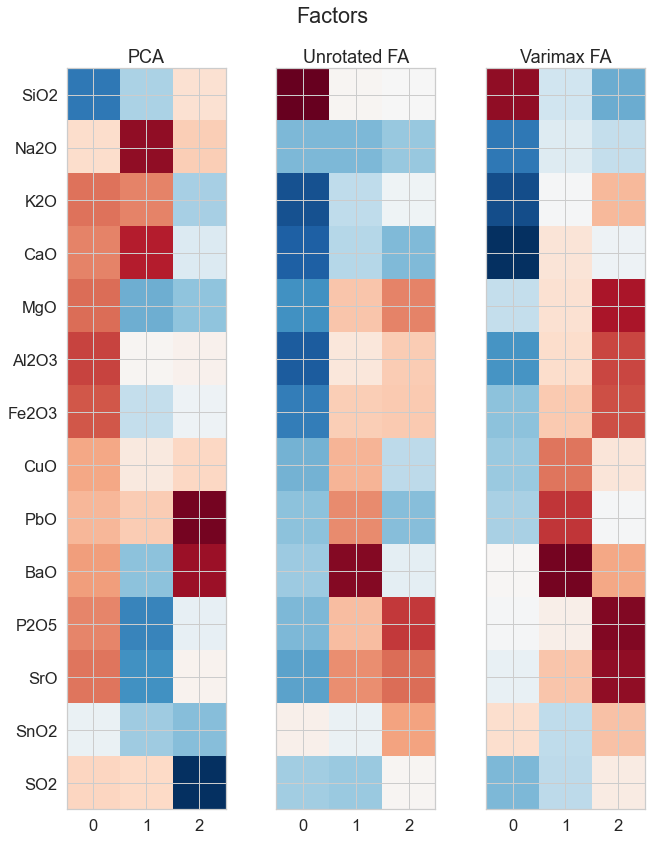

In [20]:
feature_names = list(X_K_std.columns)
n_comps = 3

methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]
fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 12))

i = 0
for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X_K_std)

    components = fa.components_.T
    print("\n\n %s :\n" % method)
    if i == 0:
        components_pca = components
        print(components_pca)
    elif i == 1:
        components_fa = components
        print(components_fa)
    else:
        components_va = components
        print(components_va)
    
    i = i+1
    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
    ax.set_xticks([0, 1, 2])
fig.suptitle("Factors")
plt.tight_layout()
plt.show()

选用基于最大方差旋转的因子分析（最后一个），得到新变量

In [21]:
new_a_K_pca = np.dot(a_K, components_pca)
new_a_K_pca

array([[-19.26929623,  -7.3249631 ,   3.58771594],
       [-30.57247775, -13.15570524,   6.54928916],
       [-13.80543148,  -5.92917269,   4.99791812],
       [-16.97766303,  -6.6177811 ,   3.03380462],
       [-13.85838398,  -5.53575038,   2.44063484],
       [-16.98934368, -12.35443372,   4.9879276 ],
       [-11.56398451,  -8.99022829,   3.62540685],
       [-12.34260693,  -2.29706364,   2.98977178],
       [-14.257726  ,  -2.34899465,   3.84744692],
       [-16.16609298,  -2.93451504,   2.72804506],
       [-26.82688628, -12.76510371,   4.10531656],
       [-24.02925147, -12.58964704,   7.72928468],
       [-34.86843216, -15.90686424,   8.13571049],
       [-36.39211991, -16.38024908,   8.06237546],
       [-37.5602187 , -16.68186039,   8.10520879],
       [-35.93881527, -16.00916025,   7.94157541],
       [-34.22542684, -15.5754353 ,   7.53264547],
       [-34.99515401, -16.12227776,   7.86154299]])

In [22]:
new_a_K_fa = np.dot(a_K, components_fa)
new_a_K_fa

array([[ 4.78946759e+01, -1.08939079e-01, -1.83604743e+00],
       [ 7.66589076e+01,  1.12353907e+00, -3.83908216e-01],
       [ 3.49255732e+01,  3.34914181e+00, -2.54599063e+00],
       [ 4.23242718e+01, -4.66475635e-01, -9.07135485e-01],
       [ 3.46741505e+01, -2.25867682e-01, -6.54273428e-01],
       [ 4.53201774e+01,  5.64678517e+00,  5.92545376e+00],
       [ 3.14187012e+01,  4.23075011e+00,  4.43710483e+00],
       [ 2.97061744e+01, -2.17018443e+00, -3.73307244e+00],
       [ 3.40779148e+01, -3.22173348e+00, -3.60423756e+00],
       [ 3.84437281e+01, -4.11169335e+00, -3.71327847e+00],
       [ 6.72026652e+01,  4.82536323e-01,  2.66879700e+00],
       [ 6.20360514e+01,  5.73667523e+00, -3.79708598e-01],
       [ 8.80939596e+01,  3.33636535e+00, -8.57667761e-01],
       [ 9.17002651e+01,  2.67236674e+00, -5.68201324e-01],
       [ 9.44575837e+01,  2.32095779e+00, -6.18926230e-01],
       [ 9.04705515e+01,  2.50224572e+00, -7.63533551e-01],
       [ 8.63637334e+01,  2.32228040e+00

In [23]:
new_a_K_va = np.dot(a_K, components_va)
new_a_K_va

array([[ 39.95560723,  -9.68690915, -24.63729198],
       [ 65.36717386, -15.50524836, -36.94208567],
       [ 30.05275546,  -3.54652955, -17.93734938],
       [ 35.41713136,  -9.1988242 , -21.29302505],
       [ 29.10830988,  -7.43945619, -17.32445058],
       [ 42.78122459,  -7.55227033, -15.28547353],
       [ 29.8992876 ,  -5.10629306, -10.23133922],
       [ 23.03712077,  -6.69032754, -18.04530165],
       [ 26.38083346,  -8.61200284, -20.36073186],
       [ 29.6985078 , -10.28656767, -22.82103964],
       [ 58.17288092, -15.35907557, -30.05941201],
       [ 54.7670755 ,  -8.31641716, -28.51192635],
       [ 75.77225356, -15.85424584, -42.18555587],
       [ 78.67529745, -17.34346465, -43.88399279],
       [ 80.8597001 , -18.22578475, -45.36005633],
       [ 77.49559012, -17.13796659, -43.50274158],
       [ 74.22292832, -16.7559244 , -40.918023  ],
       [ 76.15169792, -16.60372513, -41.85441703]])

##### 根据专业知识（论文）分类降维

In [24]:
def combine(a_K):
    com_K = a_K.copy()
    com_K['SiO2'] = com_K['SiO2']+com_K['P2O5']+com_K['Al2O3']+com_K['Fe2O3']+com_K['PbO']
    com_K['R2O'] = com_K['Na2O']+com_K['K2O']
    com_K['RO'] = com_K['CaO']+com_K['MgO']+com_K['CuO']+com_K['BaO']+com_K['SrO']
    com_K = com_K.drop(columns={'Na2O','K2O','CaO','MgO','Al2O3','Fe2O3','CuO','PbO','BaO','P2O5','SrO','SnO2','SO2'})
    return com_K
com_K = combine(a_K)
com_K

,SiO2,R2O,RO
0,76.17,9.99,11.06
1,92.02,5.19,2.79
2,71.48,12.37,15.03
3,75.17,9.67,10.86
4,72.64,10.95,12.45
5,85.57,7.37,5.98
6,80.75,7.68,10.41
7,69.32,15.39,13.43
8,73.98,15.66,9.36
9,71.89,16.62,9.90


### Kmeans

In [25]:
from sklearn.cluster import KMeans
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
np.random.seed(42)

##### 主成分分析

找到最佳簇数

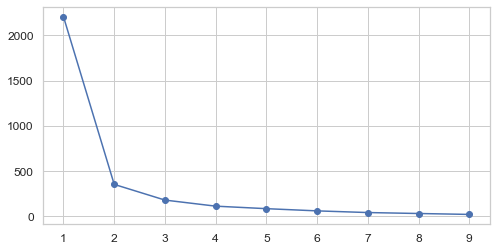

In [26]:
kmeans_per_k = [KMeans(n_clusters = k).fit(new_a_K_pca) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8,4))
plt.plot(range(1,10),inertias,'bo-')
plt.show()

In [27]:
from sklearn.metrics import silhouette_score
# 通过平均轮廓系数检验得到最佳KMeans聚类模型
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 5):  # 遍历从2到5几个有限组
    model_kmeans = KMeans(n_clusters=n_clusters)  # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(new_a_K_pca)  # 训练聚类模型
    silhouette_tmp = silhouette_score(new_a_K_pca, labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 保存K将最好的K存储下来
        silhouette_int = silhouette_tmp  # 保存平均轮廓得分
        best_kmeans = model_kmeans  # 保存模型实例对象
        cluster_labels_k = labels_tmp  # 保存聚类标签
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print('{:*^60}'.format('K值对应的轮廓系数:'))
print(np.array(score_list))  # 打印输出所有K下的详细得分
print('最优的K值是:{0} \n对应的轮廓系数是:{1}'.format(best_k, silhouette_int))

*************************K值对应的轮廓系数:*************************
[[2.         0.69403489]
 [3.         0.63841377]
 [4.         0.49687197]]
最优的K值是:2 
对应的轮廓系数是:0.694034890038566


结果

In [28]:
k = 2
kmeans_K_2 = KMeans(n_clusters = k,random_state=42)
y_pred_K_2 =  kmeans_K_2.fit_predict(new_a_K_pca)
y_pred_K_2

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

中心

In [29]:
kmeans_K_2.cluster_centers_

array([[-15.02561431,  -6.03698918,   3.58207464],
       [-32.82319804, -15.02070033,   7.33588322]])

评估

In [30]:
kmeans_K_2.inertia_

354.56400393685215

可视化

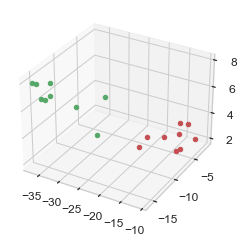

In [31]:
import csv
A = np.array(new_a_K_pca)
num_K_2, dim_K_2 = new_a_K_pca.shape
color = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
ax = plt.subplot(111, projection='3d')
f = open('result_K_2.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(f)
for p in range(0,num_K_2):
    y=y_pred_K_2[p]
    csv_writer.writerow([y])
    ax.scatter(int(A[p, 0]), int(A[p, 1]), int(A[p, 2]), c=color[int(y)])
f.close()
plt.show()

含标签数据

In [32]:
cluster_labels_K_2 = pd.DataFrame(y_pred_K_2, columns=['clusters'])  
merge_data_K_2 = pd.concat((a_K, cluster_labels_K_2), axis=1)  
merge_data_K_2

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2,clusters
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.00,0.39,0
1,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.00,0.00,1
2,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.00,0.00,0
3,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.00,0.36,0
4,61.58,0.00,10.95,7.35,1.77,7.50,2.62,3.27,0.00,0.00,0.94,0.06,0.00,0.47,0
5,67.65,0.00,7.37,0.00,1.98,11.15,2.39,2.51,0.20,1.38,4.18,0.11,0.00,0.00,0
6,59.81,0.00,7.68,5.41,1.73,10.05,6.04,2.18,0.35,0.97,4.50,0.12,0.00,0.00,0
7,59.01,2.86,12.53,8.70,0.00,6.16,2.88,4.73,0.00,0.00,1.27,0.00,0.00,0.00,0
8,62.47,3.38,12.28,8.23,0.66,9.23,0.50,0.47,1.62,0.00,0.16,0.00,0.00,0.00,0
9,65.18,2.10,14.52,8.27,0.52,6.18,0.42,1.07,0.11,0.00,0.00,0.04,0.00,0.00,0


各类别中元素均值

In [33]:
count_list = []
perce_list = []
for i in range(2):
    count = len(merge_data_K_2[merge_data_K_2['clusters'] == i])
    count_list.append(count)
    perce = len(merge_data_K_2[merge_data_K_2['clusters'] == i]) / len(merge_data_K_2)
    perce_list.append(perce)
    
number_pd_K_2 = pd.DataFrame({'counts':count_list,'percentage':perce_list}).T

# 计算各个聚类类别内部最显著特征值
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(k):  # 读取每个类索引
    label_data = merge_data_K_2[merge_data_K_2['clusters'] == line]  # 获得特定类的数据

    part_data = label_data[list(merge_data_K_2.columns)[0:14]] # 获得数值型数据特征
    part_desc = part_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part_desc.iloc[1, :]  # 得到数值型特征的均值

    cluster_features.append(merge_data1)
#  输出完整的类别特征信息
cluster_pd_K_2 = pd.DataFrame(cluster_features, index=[0, 1]).T  # 将列表转化为矩阵
all_cluster_set = pd.concat((number_pd_K_2, cluster_pd_K_2), axis=0)
print('{:*^60}'.format('每个类别主要的特征:'))
print(all_cluster_set)

*************************每个类别主要的特征:*************************
                 0       1
counts       9.000   9.000
percentage   0.500   0.500
SiO2        63.624  89.663
Na2O         0.927   0.000
K2O         10.818   1.986
CaO          6.363   1.327
MgO          1.133   0.437
Al2O3        7.349   2.764
Fe2O3        2.312   0.440
CuO          2.819   1.492
PbO          0.410   0.139
BaO          0.579   0.219
P2O5         1.523   0.533
SrO          0.048   0.008
SnO2         0.000   0.262
SO2          0.136   0.000


最大最小值处理

In [34]:
#各类别数据预处理
from sklearn.preprocessing import MinMaxScaler
model_scaler = MinMaxScaler()
num_sets = cluster_pd_K_2.iloc[:14, :].T.astype(np.float64)  # 获取要展示的数据
num_sets_max_min = model_scaler.fit_transform(num_sets)  # 获得标准化后的数据
print(num_sets_max_min)

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


各类别的显著元素特征

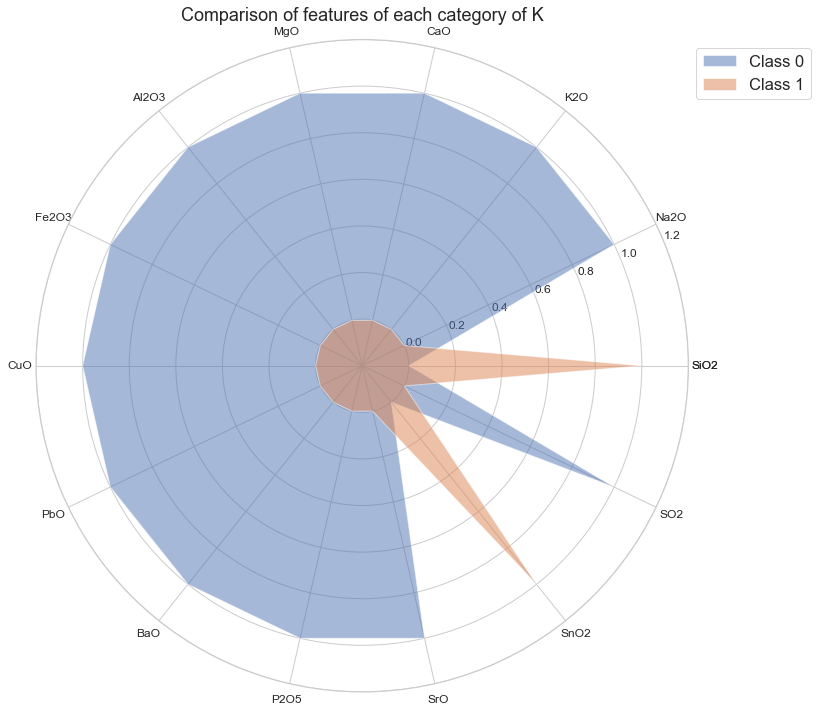

In [35]:
# 画图
fig = plt.figure(figsize=(12,12))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index)  # 设置要展示的数据标签
cor_list = ['g', 'r', 'y', 'b','o','PuRd','YlGnBu']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
labels = np.concatenate((labels, [labels[0]]))
# 画雷达图
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
#     ax.plot(angles, data, 'o-', c=cor_list[i], label="第%d类高钾玻璃"%(i))  # 画线
    ax.fill(angles, data,alpha=0.5)
# 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels)  # 设置极坐标轴
ax.set_title("Comparison of features of each category of K")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(['Class 0', 'Class 1'], loc="upper right" ,bbox_to_anchor=(1.2,1.0))  # 设置图例位置
# plt.savefig(u'a.png' )
plt.show()

##### 不旋转的因子分析

找到最佳簇数

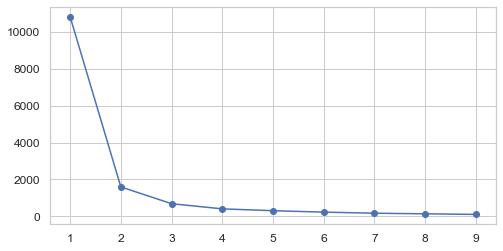

In [36]:
kmeans_per_k = [KMeans(n_clusters = k).fit(new_a_K_fa) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8,4))
plt.plot(range(1,10),inertias,'bo-')
plt.show()

In [37]:
from sklearn.metrics import silhouette_score
# 通过平均轮廓系数检验得到最佳KMeans聚类模型
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 5):  # 遍历从2到5几个有限组
    model_kmeans = KMeans(n_clusters=n_clusters)  # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(new_a_K_fa)  # 训练聚类模型
    silhouette_tmp = silhouette_score(new_a_K_fa, labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 保存K将最好的K存储下来
        silhouette_int = silhouette_tmp  # 保存平均轮廓得分
        best_kmeans = model_kmeans  # 保存模型实例对象
        cluster_labels_k = labels_tmp  # 保存聚类标签
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print('{:*^60}'.format('K值对应的轮廓系数:'))
print(np.array(score_list))  # 打印输出所有K下的详细得分
print('最优的K值是:{0} \n对应的轮廓系数是:{1}'.format(best_k, silhouette_int))

*************************K值对应的轮廓系数:*************************
[[2.         0.70900201]
 [3.         0.66715821]
 [4.         0.53226886]]
最优的K值是:2 
对应的轮廓系数是:0.7090020062291436


结果

In [38]:
k = 2
kmeans_K_2 = KMeans(n_clusters = k,random_state=42)
y_pred_K_2 =  kmeans_K_2.fit_predict(new_a_K_fa)
y_pred_K_2

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

中心

In [39]:
kmeans_K_2.cluster_centers_

array([[37.64281858,  0.3246426 , -0.73683076],
       [82.82254165,  2.60319766, -0.10958786]])

评估

In [40]:
kmeans_K_2.inertia_

1596.345245595447

可视化

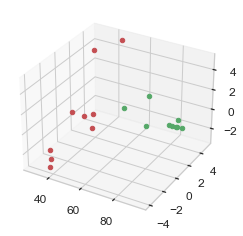

In [41]:
import csv
A = np.array(new_a_K_fa)
num_K_2, dim_K_2 = new_a_K_fa.shape
color = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
ax = plt.subplot(111, projection='3d')
f = open('result_K_2.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(f)
for p in range(0,num_K_2):
    y=y_pred_K_2[p]
    csv_writer.writerow([y])
    ax.scatter(int(A[p, 0]), int(A[p, 1]), int(A[p, 2]), c=color[int(y)])
f.close()
plt.show()

含标签数据

In [42]:
cluster_labels_K_2 = pd.DataFrame(y_pred_K_2, columns=['clusters'])  
merge_data_K_2 = pd.concat((a_K, cluster_labels_K_2), axis=1)  
merge_data_K_2

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2,clusters
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.00,0.39,0
1,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.00,0.00,1
2,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.00,0.00,0
3,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.00,0.36,0
4,61.58,0.00,10.95,7.35,1.77,7.50,2.62,3.27,0.00,0.00,0.94,0.06,0.00,0.47,0
5,67.65,0.00,7.37,0.00,1.98,11.15,2.39,2.51,0.20,1.38,4.18,0.11,0.00,0.00,0
6,59.81,0.00,7.68,5.41,1.73,10.05,6.04,2.18,0.35,0.97,4.50,0.12,0.00,0.00,0
7,59.01,2.86,12.53,8.70,0.00,6.16,2.88,4.73,0.00,0.00,1.27,0.00,0.00,0.00,0
8,62.47,3.38,12.28,8.23,0.66,9.23,0.50,0.47,1.62,0.00,0.16,0.00,0.00,0.00,0
9,65.18,2.10,14.52,8.27,0.52,6.18,0.42,1.07,0.11,0.00,0.00,0.04,0.00,0.00,0


各类别中元素均值

In [43]:
count_list = []
perce_list = []
for i in range(2):
    count = len(merge_data_K_2[merge_data_K_2['clusters'] == i])
    count_list.append(count)
    perce = len(merge_data_K_2[merge_data_K_2['clusters'] == i]) / len(merge_data_K_2)
    perce_list.append(perce)
    
number_pd_K_2 = pd.DataFrame({'counts':count_list,'percentage':perce_list}).T

# 计算各个聚类类别内部最显著特征值
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(k):  # 读取每个类索引
    label_data = merge_data_K_2[merge_data_K_2['clusters'] == line]  # 获得特定类的数据

    part_data = label_data[list(merge_data_K_2.columns)[0:14]] # 获得数值型数据特征
    part_desc = part_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part_desc.iloc[1, :]  # 得到数值型特征的均值

    cluster_features.append(merge_data1)
#  输出完整的类别特征信息
cluster_pd_K_2 = pd.DataFrame(cluster_features, index=[0, 1]).T  # 将列表转化为矩阵
all_cluster_set = pd.concat((number_pd_K_2, cluster_pd_K_2), axis=0)
print('{:*^60}'.format('每个类别主要的特征:'))
print(all_cluster_set)

*************************每个类别主要的特征:*************************
                 0       1
counts       9.000   9.000
percentage   0.500   0.500
SiO2        63.624  89.663
Na2O         0.927   0.000
K2O         10.818   1.986
CaO          6.363   1.327
MgO          1.133   0.437
Al2O3        7.349   2.764
Fe2O3        2.312   0.440
CuO          2.819   1.492
PbO          0.410   0.139
BaO          0.579   0.219
P2O5         1.523   0.533
SrO          0.048   0.008
SnO2         0.000   0.262
SO2          0.136   0.000


最大最小值处理

In [44]:
#各类别数据预处理
from sklearn.preprocessing import MinMaxScaler
model_scaler = MinMaxScaler()
num_sets = cluster_pd_K_2.iloc[:14, :].T.astype(np.float64)  # 获取要展示的数据
num_sets_max_min = model_scaler.fit_transform(num_sets)  # 获得标准化后的数据
print(num_sets_max_min)

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


各类别的显著元素特征

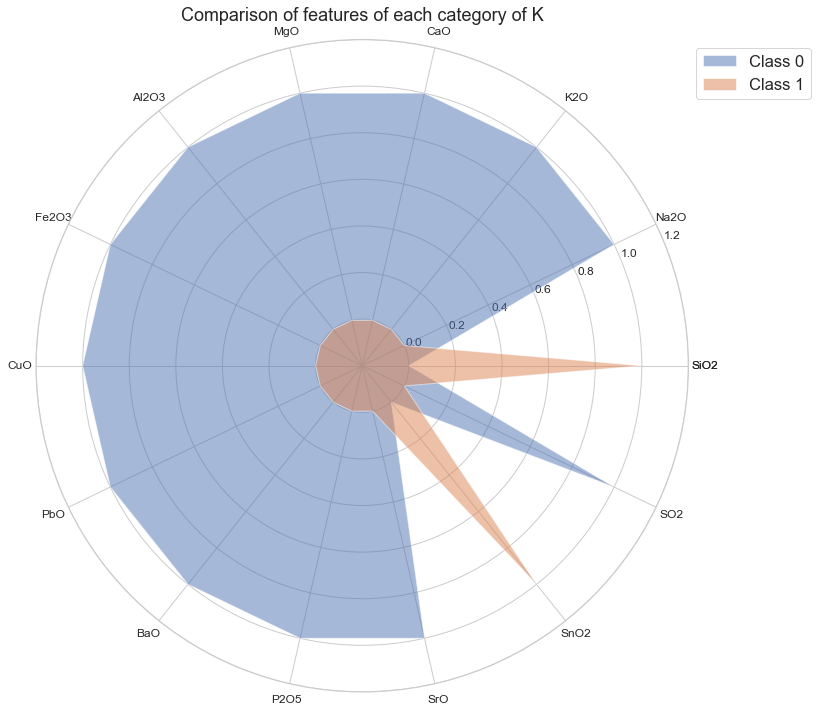

In [45]:
# 画图
fig = plt.figure(figsize=(12,12))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index)  # 设置要展示的数据标签
cor_list = ['g', 'r', 'y', 'b','o','PuRd','YlGnBu']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
labels = np.concatenate((labels, [labels[0]]))
# 画雷达图
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
#     ax.plot(angles, data, 'o-', c=cor_list[i], label="第%d类高钾玻璃"%(i))  # 画线
    ax.fill(angles, data,alpha=0.5)
# 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels)  # 设置极坐标轴
ax.set_title("Comparison of features of each category of K")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(['Class 0', 'Class 1'], loc="upper right" ,bbox_to_anchor=(1.2,1.0))  # 设置图例位置
# plt.savefig(u'a.png' )
plt.show()

##### 基于最大方差旋转的因子分析

找到最佳簇数

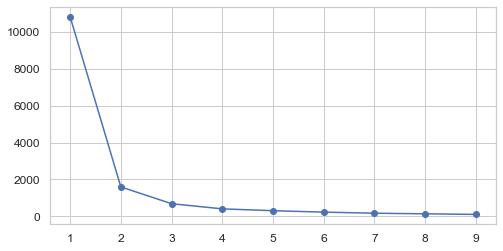

In [46]:
kmeans_per_k = [KMeans(n_clusters = k).fit(new_a_K_va) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8,4))
plt.plot(range(1,10),inertias,'bo-')
plt.show()

In [47]:
from sklearn.metrics import silhouette_score
# 通过平均轮廓系数检验得到最佳KMeans聚类模型
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 5):  # 遍历从2到5几个有限组
    model_kmeans = KMeans(n_clusters=n_clusters)  # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(new_a_K_va)  # 训练聚类模型
    silhouette_tmp = silhouette_score(new_a_K_va, labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 保存K将最好的K存储下来
        silhouette_int = silhouette_tmp  # 保存平均轮廓得分
        best_kmeans = model_kmeans  # 保存模型实例对象
        cluster_labels_k = labels_tmp  # 保存聚类标签
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print('{:*^60}'.format('K值对应的轮廓系数:'))
print(np.array(score_list))  # 打印输出所有K下的详细得分
print('最优的K值是:{0} \n对应的轮廓系数是:{1}'.format(best_k, silhouette_int))

*************************K值对应的轮廓系数:*************************
[[2.         0.70900201]
 [3.         0.66715821]
 [4.         0.53226886]]
最优的K值是:2 
对应的轮廓系数是:0.7090020062291441


结果

In [48]:
k = 2
kmeans_K_2 = KMeans(n_clusters = k,random_state=42)
y_pred_K_2 =  kmeans_K_2.fit_predict(new_a_K_va)
y_pred_K_2

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

中心

In [49]:
kmeans_K_2.cluster_centers_

array([[ 31.8145309 ,  -7.56879784, -18.65955588],
       [ 71.27606642, -15.67798361, -39.24646785]])

评估

In [50]:
kmeans_K_2.inertia_

1596.3452455954464

可视化

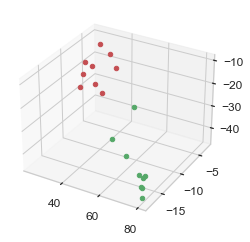

In [51]:
import csv
A = np.array(new_a_K_va)
num_K_2, dim_K_2 = new_a_K_va.shape
color = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
ax = plt.subplot(111, projection='3d')
f = open('result_K_2.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(f)
for p in range(0,num_K_2):
    y=y_pred_K_2[p]
    csv_writer.writerow([y])
    ax.scatter(int(A[p, 0]), int(A[p, 1]), int(A[p, 2]), c=color[int(y)])
f.close()
plt.show()

含标签数据

In [52]:
cluster_labels_K_2 = pd.DataFrame(y_pred_K_2, columns=['clusters'])  
merge_data_K_2 = pd.concat((a_K, cluster_labels_K_2), axis=1)  
merge_data_K_2

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2,clusters
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.00,0.39,0
1,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.00,0.00,1
2,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.00,0.00,0
3,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.00,0.36,0
4,61.58,0.00,10.95,7.35,1.77,7.50,2.62,3.27,0.00,0.00,0.94,0.06,0.00,0.47,0
5,67.65,0.00,7.37,0.00,1.98,11.15,2.39,2.51,0.20,1.38,4.18,0.11,0.00,0.00,0
6,59.81,0.00,7.68,5.41,1.73,10.05,6.04,2.18,0.35,0.97,4.50,0.12,0.00,0.00,0
7,59.01,2.86,12.53,8.70,0.00,6.16,2.88,4.73,0.00,0.00,1.27,0.00,0.00,0.00,0
8,62.47,3.38,12.28,8.23,0.66,9.23,0.50,0.47,1.62,0.00,0.16,0.00,0.00,0.00,0
9,65.18,2.10,14.52,8.27,0.52,6.18,0.42,1.07,0.11,0.00,0.00,0.04,0.00,0.00,0


各类别中元素均值

In [53]:
count_list = []
perce_list = []
for i in range(2):
    count = len(merge_data_K_2[merge_data_K_2['clusters'] == i])
    count_list.append(count)
    perce = len(merge_data_K_2[merge_data_K_2['clusters'] == i]) / len(merge_data_K_2)
    perce_list.append(perce)
    
number_pd_K_2 = pd.DataFrame({'counts':count_list,'percentage':perce_list}).T

# 计算各个聚类类别内部最显著特征值
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(k):  # 读取每个类索引
    label_data = merge_data_K_2[merge_data_K_2['clusters'] == line]  # 获得特定类的数据

    part_data = label_data[list(merge_data_K_2.columns)[0:14]] # 获得数值型数据特征
    part_desc = part_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part_desc.iloc[1, :]  # 得到数值型特征的均值

    cluster_features.append(merge_data1)
#  输出完整的类别特征信息
cluster_pd_K_2 = pd.DataFrame(cluster_features, index=[0, 1]).T  # 将列表转化为矩阵
all_cluster_set = pd.concat((number_pd_K_2, cluster_pd_K_2), axis=0)
print('{:*^60}'.format('每个类别主要的特征:'))
print(all_cluster_set)

*************************每个类别主要的特征:*************************
                 0       1
counts       9.000   9.000
percentage   0.500   0.500
SiO2        63.624  89.663
Na2O         0.927   0.000
K2O         10.818   1.986
CaO          6.363   1.327
MgO          1.133   0.437
Al2O3        7.349   2.764
Fe2O3        2.312   0.440
CuO          2.819   1.492
PbO          0.410   0.139
BaO          0.579   0.219
P2O5         1.523   0.533
SrO          0.048   0.008
SnO2         0.000   0.262
SO2          0.136   0.000


最大最小值处理

In [54]:
#各类别数据预处理
from sklearn.preprocessing import MinMaxScaler
model_scaler = MinMaxScaler()
num_sets = cluster_pd_K_2.iloc[:14, :].T.astype(np.float64)  # 获取要展示的数据
num_sets_max_min = model_scaler.fit_transform(num_sets)  # 获得标准化后的数据
print(num_sets_max_min)

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


各类别的显著元素特征

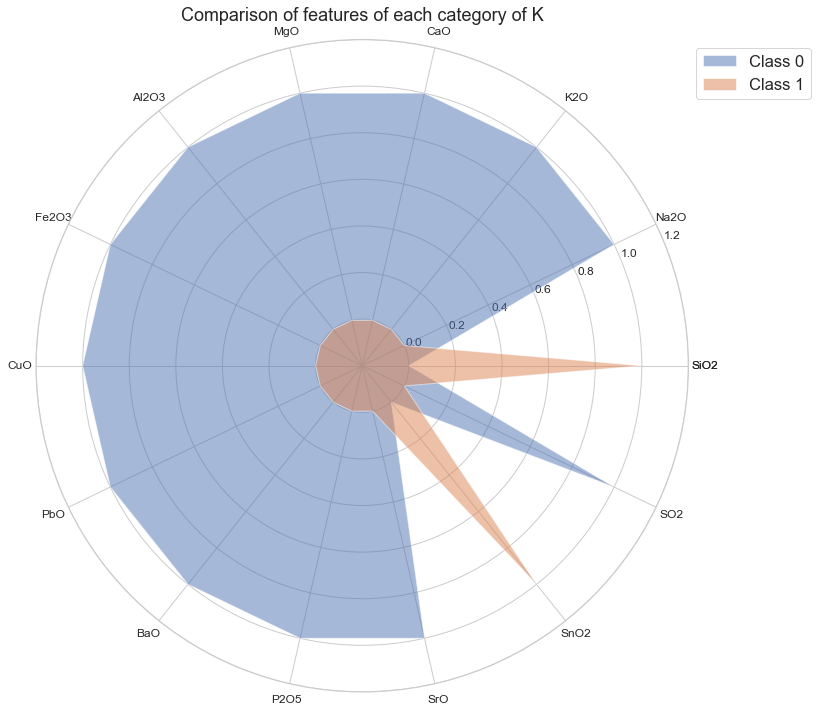

In [55]:
# 画图
fig = plt.figure(figsize=(12,12))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index)  # 设置要展示的数据标签
cor_list = ['g', 'r', 'y', 'b','o','PuRd','YlGnBu']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
labels = np.concatenate((labels, [labels[0]]))
# 画雷达图
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
#     ax.plot(angles, data, 'o-', c=cor_list[i], label="第%d类高钾玻璃"%(i))  # 画线
    ax.fill(angles, data,alpha=0.5)
# 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels)  # 设置极坐标轴
ax.set_title("Comparison of features of each category of K")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(['Class 0', 'Class 1'], loc="upper right" ,bbox_to_anchor=(1.2,1.0))  # 设置图例位置
# plt.savefig(u'a.png' )
plt.show()

##### 根据专业知识（论文）分类降维

找到最佳簇数

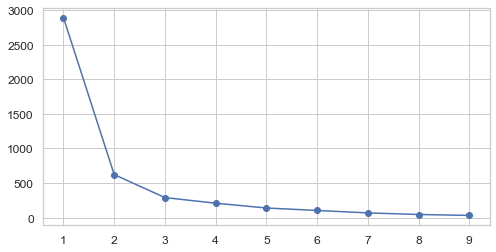

In [56]:
kmeans_per_k = [KMeans(n_clusters = k).fit(com_K) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8,4))
plt.plot(range(1,10),inertias,'bo-')
plt.show()

In [57]:
from sklearn.metrics import silhouette_score
# 通过平均轮廓系数检验得到最佳KMeans聚类模型
score_list = list()  # 用来存储每个K下模型的平局轮廓系数
silhouette_int = -1  # 初始化的平均轮廓系数阀值
for n_clusters in range(2, 5):  # 遍历从2到5几个有限组
    model_kmeans = KMeans(n_clusters=n_clusters)  # 建立聚类模型对象
    labels_tmp = model_kmeans.fit_predict(com_K)  # 训练聚类模型
    silhouette_tmp = silhouette_score(com_K, labels_tmp)  # 得到每个K下的平均轮廓系数
    if silhouette_tmp > silhouette_int:  # 如果平均轮廓系数更高
        best_k = n_clusters  # 保存K将最好的K存储下来
        silhouette_int = silhouette_tmp  # 保存平均轮廓得分
        best_kmeans = model_kmeans  # 保存模型实例对象
        cluster_labels_k = labels_tmp  # 保存聚类标签
    score_list.append([n_clusters, silhouette_tmp])  # 将每次K及其得分追加到列表
print('{:*^60}'.format('K值对应的轮廓系数:'))
print(np.array(score_list))  # 打印输出所有K下的详细得分
print('最优的K值是:{0} \n对应的轮廓系数是:{1}'.format(best_k, silhouette_int))

*************************K值对应的轮廓系数:*************************
[[2.         0.63505266]
 [3.         0.58887095]
 [4.         0.55894944]]
最优的K值是:2 
对应的轮廓系数是:0.6350526641906415


结果

In [58]:
k_com = 2
kmeans_K_com = KMeans(n_clusters = k_com,random_state=42)
y_pred_K_com =  kmeans_K_com.fit_predict(com_K)
y_pred_K_com

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

中心

In [59]:
kmeans_K_com.cluster_centers_

array([[73.925  , 12.29125, 11.5625 ],
       [92.743  ,  2.524  ,  3.732  ]])

评估

In [60]:
kmeans_K_com.inertia_

620.8776474999997

可视化

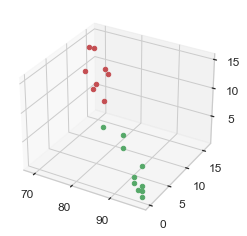

In [61]:
import csv
A = np.array(com_K)
num_K_com, dim_K_com = com_K.shape
color = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
ax = plt.subplot(111, projection='3d')
f = open('result_K_com.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(f)
for p in range(0,num_K_com):
    y=y_pred_K_com[p]
    csv_writer.writerow([y])
    ax.scatter(int(A[p, 0]), int(A[p, 1]), int(A[p, 2]), c=color[int(y)], alpha=1)
f.close()
plt.show()

含标签数据

In [62]:
cluster_labels_K_com = pd.DataFrame(y_pred_K_com, columns=['clusters'])  
merge_data_K_com = pd.concat((com_K, cluster_labels_K_com), axis=1)  
merge_data_K_com

,SiO2,R2O,RO,clusters
0,76.17,9.99,11.06,0
1,92.02,5.19,2.79,1
2,71.48,12.37,15.03,0
3,75.17,9.67,10.86,0
4,72.64,10.95,12.45,0
5,85.57,7.37,5.98,1
6,80.75,7.68,10.41,0
7,69.32,15.39,13.43,0
8,73.98,15.66,9.36,0
9,71.89,16.62,9.90,0


各类别中元素均值

In [63]:
count_list = []
perce_list = []
for i in range(2):
    count = len(merge_data_K_com[merge_data_K_com['clusters'] == i])
    count_list.append(count)
    perce = len(merge_data_K_com[merge_data_K_com['clusters'] == i]) / len(merge_data_K_com)
    perce_list.append(perce)
    
number_pd_K_com = pd.DataFrame({'counts':count_list,'percentage':perce_list}).T

# 计算各个聚类类别内部最显著特征值
cluster_features = []  # 空列表，用于存储最终合并后的所有特征信息
for line in range(k_com):  # 读取每个类索引
    label_data = merge_data_K_com[merge_data_K_com['clusters'] == line]  # 获得特定类的数据

    part_data = label_data[list(merge_data_K_com.columns)[0:3]] # 获得数值型数据特征
    part_desc = part_data.describe().round(3)  # 得到数值型特征的描述性统计信息
    merge_data1 = part_desc.iloc[1, :]  # 得到数值型特征的均值

    cluster_features.append(merge_data1)
#  输出完整的类别特征信息
cluster_pd_K_com = pd.DataFrame(cluster_features, index=[0, 1]).T  # 将列表转化为矩阵
all_cluster_set = pd.concat((number_pd_K_com, cluster_pd_K_com), axis=0)
print('{:*^60}'.format('每个类别主要的特征:'))
print(all_cluster_set)

*************************每个类别主要的特征:*************************
                    0          1
counts       8.000000  10.000000
percentage   0.444444   0.555556
SiO2        73.925000  92.743000
R2O         12.291000   2.524000
RO          11.562000   3.732000


最大最小值处理

In [64]:
#各类别数据预处理
from sklearn.preprocessing import MinMaxScaler
model_scaler = MinMaxScaler()
num_sets = cluster_pd_K_com.iloc[:3, :].T.astype(np.float64)  # 获取要展示的数据
num_sets_max_min = model_scaler.fit_transform(num_sets)  # 获得标准化后的数据
print(num_sets_max_min)

[[0. 1. 1.]
 [1. 0. 0.]]


各类别的显著元素特征

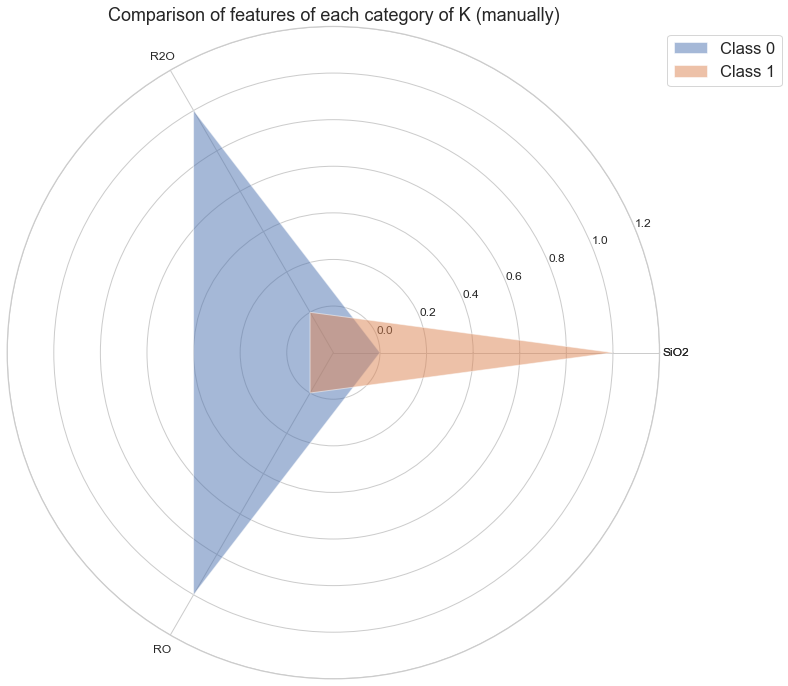

In [65]:
# 画图
fig = plt.figure(figsize=(12,12))  # 建立画布
ax = fig.add_subplot(111, polar=True)  # 增加子网格，注意polar参数
labels = np.array(merge_data1.index)  # 设置要展示的数据标签
cor_list = ['g', 'r', 'y', 'b','o','PuRd','YlGnBu']  # 定义不同类别的颜色
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)  # 计算各个区间的角度
angles = np.concatenate((angles, [angles[0]]))  # 建立相同首尾字段以便于闭合
labels = np.concatenate((labels, [labels[0]]))
# 画雷达图
for i in range(len(num_sets)):  # 循环每个类别
    data_tmp = num_sets_max_min[i, :]  # 获得对应类数据
    data = np.concatenate((data_tmp, [data_tmp[0]]))  # 建立相同首尾字段以便于闭合
#     ax.plot(angles, data, 'o-', c=cor_list[i], label="第%d类高钾玻璃"%(i))  # 画线
    ax.fill(angles, data,alpha=0.5)
# 设置图像显示格式
ax.set_thetagrids(angles * 180 / np.pi, labels)  # 设置极坐标轴
ax.set_title("Comparison of features of each category of K (manually)")  # 设置标题放置
ax.set_rlim(-0.2, 1.2)  # 设置坐标轴尺度范围
plt.legend(['Class 0', 'Class 1'], loc="upper right" ,bbox_to_anchor=(1.2,1.0))  # 设置图例位置
# plt.savefig(u'a.png' )
plt.show()

### 可靠性分析（选用PCA进行降维：inertia_=354, 轮廓系数=0.69）

In [66]:
kmeans_K_com_1 = KMeans(n_clusters = 2,random_state=42,init='random')
y_pred_K_com_1 =  kmeans_K_com_1.fit_predict(new_a_K_pca)
y_pred_K_com_1

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [67]:
kmeans_K_com_2 = KMeans(n_clusters = 2,random_state=42,algorithm='elkan')
y_pred_K_com_2 =  kmeans_K_com_2.fit_predict(new_a_K_pca)
y_pred_K_com_2

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [71]:
kmeans_K_com_3 = KMeans(n_clusters = 2,random_state=42,algorithm='auto')
y_pred_K_com_3 =  kmeans_K_com_3.fit_predict(new_a_K_pca)
y_pred_K_com_3

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [72]:
kmeans_K_com_4 = KMeans(n_clusters = 2,random_state=42,algorithm='full')
y_pred_K_com_4 =  kmeans_K_com_4.fit_predict(new_a_K_pca)
y_pred_K_com_4

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [73]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=2,
        assign_labels='discretize',
        random_state=42).fit(new_a_K_pca)
clustering.labels_

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

结果一点都没变（除了分的类的标签不同）

### 敏感性分析（选用PCA进行降维：inertia_=354, 轮廓系数=0.69）

In [90]:
a_K_jittered = a_K.copy()
a_K_jittered

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2
0,69.33,0.00,9.99,6.32,0.87,3.93,1.74,3.87,0.00,0.00,1.17,0.00,0.00,0.39
1,87.05,0.00,5.19,2.01,0.00,4.06,0.00,0.78,0.25,0.00,0.66,0.00,0.00,0.00
2,61.71,0.00,12.37,5.87,1.11,5.50,2.16,5.09,1.41,2.86,0.70,0.10,0.00,0.00
3,65.88,0.00,9.67,7.12,1.56,6.44,2.06,2.18,0.00,0.00,0.79,0.00,0.00,0.36
4,61.58,0.00,10.95,7.35,1.77,7.50,2.62,3.27,0.00,0.00,0.94,0.06,0.00,0.47
5,67.65,0.00,7.37,0.00,1.98,11.15,2.39,2.51,0.20,1.38,4.18,0.11,0.00,0.00
6,59.81,0.00,7.68,5.41,1.73,10.05,6.04,2.18,0.35,0.97,4.50,0.12,0.00,0.00
7,59.01,2.86,12.53,8.70,0.00,6.16,2.88,4.73,0.00,0.00,1.27,0.00,0.00,0.00
8,62.47,3.38,12.28,8.23,0.66,9.23,0.50,0.47,1.62,0.00,0.16,0.00,0.00,0.00
9,65.18,2.10,14.52,8.27,0.52,6.18,0.42,1.07,0.11,0.00,0.00,0.04,0.00,0.00


In [91]:
col_list_in = []
row_list_in = []
col_list_de = []
row_list_de = []
import random
for i in range(50):
    col_list_in.append(random.randint(0,13))
    row_list_in.append(random.randint(0,7))
for i in range(50):
    col_list_de.append(random.randint(0,13))
    row_list_de.append(random.randint(0,7))
tuple_list_in = list(zip(row_list_in, col_list_in))
tuple_list_de = list(zip(row_list_de, col_list_de))

In [92]:
for coordinate in tuple_list_in:
    if coordinate[1] == 1 or coordinate[1] == 9:
        a_K_jittered.iloc[coordinate] = a_K_jittered.iloc[coordinate] * 1.05
    else:
        a_K_jittered.iloc[coordinate] = a_K_jittered.iloc[coordinate] * 1.1
for coordinate in tuple_list_de:
    if coordinate[1] == 1 or coordinate[1] == 9:
        a_K_jittered.iloc[coordinate] = a_K_jittered.iloc[coordinate] / 1.05
    else:
        a_K_jittered.iloc[coordinate] = a_K_jittered.iloc[coordinate] / 1.1
cols = list(a_K_jittered.columns)[0:14]
a_K_jittered['total'] = a_K_jittered[cols].sum(axis=1)
a_K_jittered

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2,total
0,69.330000,0.00000,9.9900,6.320000,0.870000,4.323000,1.581818,3.518182,0.00000,0.000000,0.966942,0.000000,0.00,0.390000,97.289942
1,87.050000,0.00000,5.1900,2.010000,0.000000,3.690909,0.000000,0.858000,0.25000,0.000000,0.660000,0.000000,0.00,0.000000,99.708909
2,61.710000,0.00000,14.9677,5.870000,1.009091,5.500000,2.376000,5.599000,1.41000,2.860000,0.700000,0.100000,0.00,0.000000,102.101791
3,72.468000,0.00000,9.6700,5.884298,1.560000,8.571640,1.872727,2.180000,0.00000,0.000000,0.718182,0.000000,0.00,0.245885,103.170731
4,67.738000,0.00000,10.9500,7.350000,1.770000,7.500000,2.620000,3.270000,0.00000,0.000000,1.034000,0.060000,0.00,0.470000,102.762000
5,67.650000,0.00000,8.1070,0.000000,1.980000,11.150000,2.172727,2.510000,0.20000,1.380000,3.454545,0.110000,0.00,0.000000,98.714273
6,54.372727,0.00000,8.4480,5.410000,1.572727,10.050000,6.644000,2.180000,0.46585,1.069425,4.500000,0.109091,0.00,0.000000,94.821820
7,53.645455,2.72381,12.5300,9.570000,0.000000,6.160000,2.880000,4.730000,0.00000,0.000000,1.270000,0.000000,0.00,0.000000,93.509264
8,62.470000,3.38000,12.2800,8.230000,0.660000,9.230000,0.500000,0.470000,1.62000,0.000000,0.160000,0.000000,0.00,0.000000,99.000000
9,65.180000,2.10000,14.5200,8.270000,0.520000,6.180000,0.420000,1.070000,0.11000,0.000000,0.000000,0.040000,0.00,0.000000,98.410000


标准化后数据

In [94]:
a_K_jittered = a_K_jittered.drop(columns={'total'})
X_K_jittered = StandardScaler().fit_transform(a_K_jittered.copy())
X_K_jittered_std = pd.DataFrame(X_K, columns=list(a_K_jittered.columns))
X_K_jittered_std

,SiO2,Na2O,K2O,CaO,MgO,Al2O3,Fe2O3,CuO,PbO,BaO,P2O5,SrO,SnO2,SO2
0,-0.520223,-0.437920,0.695655,0.769848,0.122877,-0.376814,0.239100,1.182219,-0.549265,-0.487689,0.113832,-0.651608,-0.242536,2.109663
1,0.740167,-0.437920,-0.234901,-0.570776,-1.134808,-0.333336,-0.904200,-0.948533,-0.048922,-0.487689,-0.295964,-0.651608,-0.242536,-0.443757
2,-1.062220,-0.437920,1.157055,0.629876,0.469825,0.148273,0.515069,2.023486,2.272666,3.009000,-0.263823,1.694180,-0.242536,-0.443757
3,-0.765616,-0.437920,0.633618,1.018688,1.120352,0.462657,0.449362,0.016856,-0.549265,-0.487689,-0.191506,-0.651608,-0.242536,1.913246
4,-1.071467,-0.437920,0.881766,1.090229,1.423931,0.817174,0.817320,0.768480,-0.549265,-0.487689,-0.070978,0.755865,-0.242536,2.633441
5,-0.639719,-0.437920,0.187727,-1.195986,1.727510,2.037919,0.666195,0.244412,-0.148991,1.199525,2.532431,1.928758,-0.242536,-0.443757
6,-1.197363,-0.437920,0.247825,0.486793,1.366106,1.670024,3.064495,0.016856,0.151215,0.698251,2.789557,2.163337,-0.242536,-0.443757
7,-1.254266,2.265210,1.188074,1.510146,-1.134808,0.369011,0.988158,1.775243,-0.549265,-0.487689,0.194184,-0.651608,-0.242536,-0.443757
8,-1.008163,2.756688,1.139608,1.363953,-0.180702,1.395774,-0.575665,-1.162298,2.692954,-0.487689,-0.697724,-0.651608,-0.242536,-0.443757
9,-0.815405,1.546896,1.573867,1.376395,-0.383088,0.375700,-0.628231,-0.748560,-0.329114,-0.487689,-0.826287,0.286707,-0.242536,-0.443757


原变量和降维后变量之间关系（原变量的系数）



 PCA :

[[-0.39752313 -0.17611856  0.08453271]
 [ 0.09758954  0.49218878  0.13591184]
 [ 0.30158088  0.27551746 -0.18266882]
 [ 0.27558527  0.43457836 -0.07483662]
 [ 0.31051253 -0.27099819 -0.22384559]
 [ 0.37446783  0.00911319  0.02435639]
 [ 0.34562259 -0.13372304 -0.02728957]
 [ 0.2137939   0.05212132  0.114424  ]
 [ 0.18271854  0.1388804   0.52884756]
 [ 0.23093599 -0.22831786  0.47440297]
 [ 0.27272979 -0.36423722 -0.04721204]
 [ 0.29461486 -0.33658521  0.01925532]
 [-0.03785446 -0.19505993 -0.23722668]
 [ 0.12006862  0.11144119 -0.55431215]]


 Unrotated FA :

[[ 0.99909443  0.02240136 -0.00564724]
 [-0.44858193 -0.44560625 -0.37982991]
 [-0.87024661 -0.25128113 -0.03994159]
 [-0.81941985 -0.28758497 -0.43742184]
 [-0.60636691  0.2750841   0.49924526]
 [-0.83220341  0.11440239  0.25642119]
 [-0.69258265  0.24695586  0.26302134]
 [-0.47371815  0.34270889 -0.26181475]
 [-0.41131874  0.47261652 -0.42870555]
 [-0.36621564  0.91614156 -0.09789424]
 [-0.45086866  0.31175002  0.70381

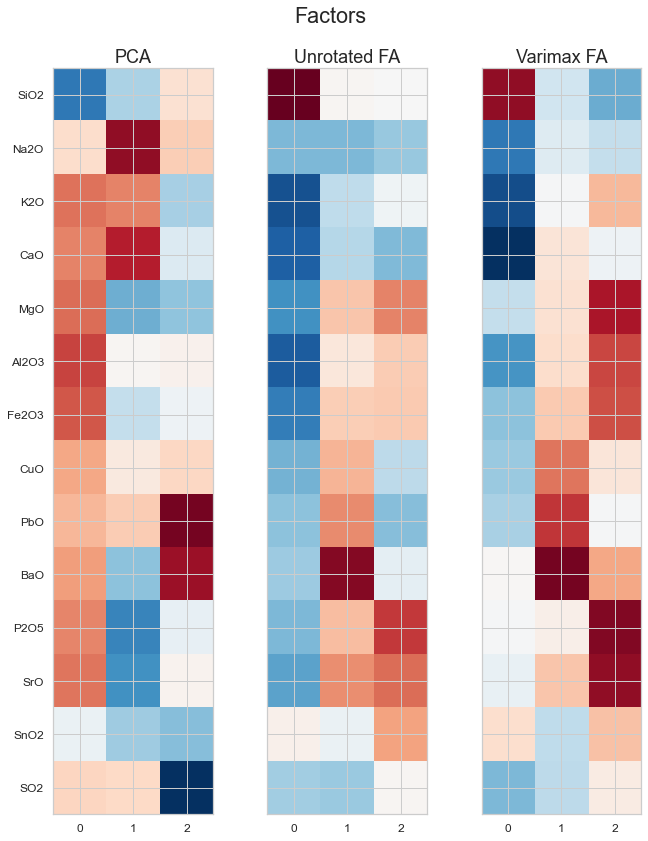

In [95]:
feature_names = list(X_K_jittered_std.columns)
n_comps = 3

methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]
fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 12))

i = 0
for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X_K_jittered_std)

    components = fa.components_.T
    print("\n\n %s :\n" % method)
    if i == 0:
        components_pca_ = components
        print(components_pca_)
    elif i == 1:
        components_fa_ = components
        print(components_fa_)
    else:
        components_va_ = components
        print(components_va_)
    
    i = i+1
    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
    ax.set_xticks([0, 1, 2])
fig.suptitle("Factors")
plt.tight_layout()
plt.show()

选用基于最大方差旋转的因子分析（最后一个），得到新变量

In [96]:
new_a_K_jittered_pca = np.dot(a_K_jittered, components_pca_)
new_a_K_jittered_pca

array([[-19.30739809,  -7.24460506,   3.57093505],
       [-30.6940145 , -13.15500337,   6.54922451],
       [-12.86987278,  -5.18846923,   4.59833466],
       [-19.23687053,  -8.25714933,   3.80685766],
       [-16.28069484,  -6.6545268 ,   2.95674933],
       [-17.04002599, -11.85808543,   4.89348015],
       [ -8.97009303,  -7.86211367,   3.15243616],
       [ -9.98360759,  -1.04121585,   2.45267446],
       [-14.257726  ,  -2.34899465,   3.84744692],
       [-16.16609298,  -2.93451504,   2.72804506],
       [-26.82688628, -12.76510371,   4.10531656],
       [-24.02925147, -12.58964704,   7.72928468],
       [-34.86843216, -15.90686424,   8.13571049],
       [-36.39211991, -16.38024908,   8.06237546],
       [-37.5602187 , -16.68186039,   8.10520879],
       [-35.93881527, -16.00916025,   7.94157541],
       [-34.22542684, -15.5754353 ,   7.53264547],
       [-34.99515401, -16.12227776,   7.86154299]])

In [97]:
k = 2
kmeans_K = KMeans(n_clusters = k,random_state=42)
y_pred_K =  kmeans_K.fit_predict(new_a_K_jittered_pca)
y_pred_K

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

结果不变